In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import re, nltk, operator, itertools, gensim, math
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from operator import itemgetter
from gensim import corpora, models

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [3]:
df = pd.read_csv('corporate_culture_trunc.csv') #reads csv into dataframe
df = df.dropna(subset=['Q1']) #drop row if no description (NaN in Q1)
culture_text=df['Q1'] #takes only the first column


###BELOW COMMANDS TOKENIZE TEXT#########

lmtzr = WordNetLemmatizer()
estopwords = set(stopwords.words('english')) #gets rid of stopwords (a, an, the...)
ostopwords = ['wa','ha']

def removewords(docwords,nmin,nmax):
    #removes words that only appear n times
    all_tokens=sum(docwords,[])
    tokens_n=set(word for word in set(all_tokens) if all_tokens.count(word)<=nmin or all_tokens.count(word)>=nmax)
    docwords = [[word for word in docs if word not in tokens_n]
                for docs in docwords]
    return docwords

def lemmat(corpus):
    nmin = 4
    nmax = len(corpus)/3
    token_corpus = [[re.sub(r'[^\w\-\s]','', word) for word in doc.lower().split()]
          for doc in corpus]
    token_corpus = [[lmtzr.lemmatize(w) for w in doc]
                for doc in token_corpus]
    token_corpus = [[w for w in doc if len(w)>1] #getting rid of words with only one letter
            for doc in token_corpus]
    token_corpus = [[w for w in doc if w not in estopwords] #getting rid of stopwords
            for doc in token_corpus]
    token_corpus = [[w for w in doc if w not in ostopwords] #getting rid of stopwords
            for doc in token_corpus]
    token_corpus = removewords(token_corpus,nmin,nmax)
    return(token_corpus)

tcorpus = lemmat(culture_text)
print("The first ten results:")
print(tcorpus[0:10])

tcorpus = [doc for doc in tcorpus if len(doc)>0] #get rid of observations with no values
print(len(tcorpus))

The first ten results:
[['integrity', 'professionalism'], ['want', u'customer', u'need', u'commitment', 'innovative', 'top', 'quality', u'product', u'service', 'competitive'], ['chaos', 'since', 'fast', 'change', 'process', 'corporate', 'culture'], ['success', 'team', 'effort'], ['dynamic', 'startup', 'culture', 'little', 'hierarchy'], ['diversity', 'excellence'], ['positive', u'attitude'], ['open', 'collaborative', 'professional', 'cooperative', 'sharing', 'direction', 'given'], [], ['family', 'oriented', 'culture', u'need', 'done', 'deliver', 'customer', 'service', 'right']]
1567


In [4]:
def joinlists(listname):
    #function for joining list of lists (i.e. from x=([['a','b'],['c']]) to x=['a','b','c'])
    #want only unique values for each document, so:
    uniquelitems = [set(listitems) for listitems in listname]
    newlist=list(itertools.chain.from_iterable(uniquelitems))
    return newlist

def word_count(toktext): 
    #function returns word frequences from an input of tokenized text
    word_freq=dict([(word, toktext.count(word)) for word in set(toktext)])
    return word_freq

def top_words(toktext,n):
    #function returns top n words in a tokenized text
    wordfreq=word_count(toktext)
    topwords=sorted(wordfreq.iteritems(),key=itemgetter(1), reverse=True)[:n]
    return topwords

tot_allwords=joinlists(tcorpus)

print("Top 100 words:")
for ind_word in top_words(tot_allwords,100):
    print ind_word

Top 100 words:
('culture', 151)
('collaborative', 124)
(u'customer', 118)
('family', 109)
('open', 94)
('oriented', 93)
('work', 82)
('focused', 81)
('team', 79)
(u'employee', 79)
('integrity', 75)
('driven', 72)
('value', 71)
(u'company', 62)
(u'service', 62)
('corporate', 57)
('entrepreneurial', 56)
('people', 56)
('business', 55)
('respect', 54)
('professional', 51)
('innovative', 49)
('client', 45)
('high', 44)
('fun', 44)
('teamwork', 41)
('focus', 39)
('friendly', 39)
('collegial', 39)
('management', 38)
('top', 38)
('ethical', 38)
('accountability', 38)
('change', 35)
('environment', 34)
('excellence', 34)
(u'result', 34)
('based', 33)
('working', 31)
('hard', 31)
('supportive', 31)
(u'good', 30)
('one', 30)
('quality', 30)
('caring', 30)
('organization', 30)
('conservative', 29)
('performance', 29)
('communication', 28)
(u'need', 28)
('relaxed', 28)
('respectful', 27)
('trust', 27)
('innovation', 26)
('right', 25)
('lack', 24)
('thing', 24)
('growth', 24)
('strong', 23)
('hones

In [5]:
dictionary = corpora.Dictionary(tcorpus)
dictionary.save('culturewords.dict') # store the dictionary, for future reference
corpus = [dictionary.doc2bow(text) for text in tcorpus]
corpora.BleiCorpus.serialize('culturewords.lda-c', corpus) # store to disk, for later use
#corpus is now in bag-of-words format (number of occurrances of each word in the dictionary in each document)

tfidf = models.TfidfModel(corpus)
corpus_tfidf=tfidf[corpus]

(1567, 401)


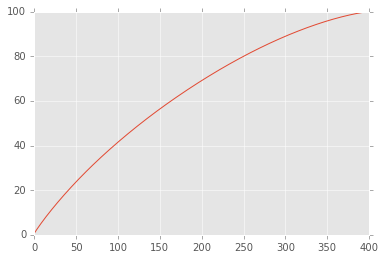

In [6]:
### CAN WE FIGURE OUT A NATURAL NUMBER OF CLUSTERS FROM THE DATA?
### LETS DO PCA AND THEN DETERMINE HOW MANY PRINCIPAL COMPONENTS TO CHOOSE
### VIA EXPLAINED VARIANCE MEASURES, CALCULATED FROM THE EIGENVALUES
### (The explained variance tells us how much information (variance) can be attributed 
### to each of the principal components.)

numpy_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
X = numpy_matrix.transpose() #each observation a row, each feature a column
X_std = StandardScaler().fit_transform(X)
print(X.shape) #401 features, 1567 observations

mean_vec = np.mean(X, axis=0)
cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0]-1)
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.plot(cum_var_exp)

The plot of Explained variance is too smooth -- not able to carry out dimension reduction or come up with a reasonable value for number of clusters

Reading more -- kmeans is a horrible clustering algorithm for categorical/ordinal data. Need to do some similarity calculations beforehand.

# DBSCAN CLUSTERING

PERHAPS DBSCAN (Density-Based Spatial Clustering of Applications with Noise) WOULD BE A BETTER CLUSTERING METHOD?

Density-based clustering algorithms attempt to capture our intuition that a cluster is a region of the data space where there are lots of points, surrounded by a region where there are few points. 

DBSCAN does this by partitioning the input data points into three types:
(1) Core points have a large number of other points within a given neighborhood. The parameter min_core_neighbors defines how many points counts as a "large number", while the radius parameter defines how large the neighborhoods are around each point. Specifically, a point y is in the neighborhood of point x if d(x,y)< radius, where d is a user-specified distance function.
(2) Boundary points are within distance radius of a core point, but don't have sufficient neighbors of their own to be considered core.
(3) Noise points comprise the remainder of the data. These points have too few neighbors to be considered core points, and are further than distance radius from all core points.


Estimated number of clusters: 3
Silhouette Coefficient: -0.234


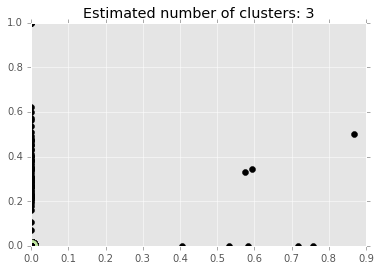

In [8]:
# Compute DBSCAN
db = DBSCAN(min_samples=15).fit(X_std)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_std, labels))

#Silhouette coefficient near 0, indicating overlapping clusters

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

TOO MUCH NOISE, NOT ENOUGH SIGNAL, TO USE THIS AS A CLUSTERING METHOD
AS THE ABOVE GRAPH SHOWS, THESE ARE VERY CRAPPY CLUSTERS.
HOWEVER, LET US TRY 3 AS THE NUMBER OF CLUSTERS ANYWAY AND SEE WHAT HAPPENS

In [9]:
num_topics=3

ldamodel = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=20, iterations=100000)
ldamodel.print_topics()

[(0,
  u'0.026*collegial + 0.022*culture + 0.018*conservative + 0.017*management + 0.017*fun + 0.015*performance + 0.015*engaged + 0.014*top + 0.013*change + 0.013*growth'),
 (1,
  u'0.026*integrity + 0.023*service + 0.019*respect + 0.014*accountability + 0.014*teamwork + 0.014*focus + 0.013*supportive + 0.012*right + 0.012*trust + 0.011*communication'),
 (2,
  u'0.051*collaborative + 0.043*family + 0.027*entrepreneurial + 0.020*value + 0.019*oriented + 0.019*open + 0.019*professional + 0.019*focused + 0.017*friendly + 0.016*driven')]

In [15]:
num_topics=7

ldamodel = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=20, iterations=100000)
ldamodel.print_topics()


[(0,
  u'0.039*management + 0.032*transparent + 0.029*culture + 0.022*changing + 0.021*engaged + 0.021*lack + 0.019*energetic + 0.018*top + 0.018*fast + 0.018*open'),
 (1,
  u'0.099*family + 0.060*collegial + 0.032*team + 0.027*first + 0.026*transition + 0.024*casual + 0.021*business + 0.019*toxic + 0.018*competitive + 0.018*accountable'),
 (2,
  u'0.093*collaborative + 0.056*entrepreneurial + 0.030*fun + 0.030*friendly + 0.028*ethical + 0.028*respectful + 0.026*family + 0.024*supportive + 0.018*open + 0.018*committed'),
 (3,
  u'0.044*professional + 0.035*driven + 0.033*relaxed + 0.025*honest + 0.022*mission + 0.022*creative + 0.020*flexible + 0.020*cooperative + 0.017*highly + 0.016*siloed'),
 (4,
  u'0.053*oriented + 0.052*innovative + 0.040*focused + 0.036*customer + 0.028*collaborative + 0.028*conservative + 0.026*open + 0.023*performance + 0.022*traditional + 0.021*high'),
 (5,
  u'0.035*employee + 0.034*client + 0.028*work + 0.027*company + 0.026*value + 0.022*caring + 0.021*peo

DOES IT REALLY MAKE SENSE TO USE LDA IN THIS MODEL?
DO WE WANT TO GIVE COMPANY CULTURE ONE LABEL, OR ALLOW THEM TO HAVE MULTIPLE LABELS? (THE DSBSCAN SEEMED TO INDICATE THAT THERE WERE OVERLAPPING CLUSTERS, WHICH INDICATES MEMBERSHIP IN MORE THAN ONE, BUT STILL.)

In [16]:
lsimodel = models.lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsimodel[corpus_tfidf]
lsimodel.print_topics(num_topics)

##THESE TOPICS DON'T MAKE SENSE, SINCE THERE ARE NEGATIVES IN THEM. ALTERNATE WAY TO GROUP:
##FIND DOCUMENTS THAT SHARE THE SAME TOPIC, TAKE THOSE TOP KEYWORDS

[(0,
  u'0.862*"collaborative" + 0.256*"family" + 0.196*"oriented" + 0.129*"open" + 0.106*"driven" + 0.106*"customer" + 0.101*"team" + 0.091*"focused" + 0.089*"innovative" + 0.084*"culture"'),
 (1,
  u'-0.806*"family" + 0.417*"collaborative" + -0.239*"oriented" + -0.115*"culture" + -0.108*"customer" + -0.096*"focused" + -0.079*"business" + -0.079*"friendly" + -0.077*"service" + -0.073*"team"'),
 (2,
  u'0.471*"family" + -0.321*"customer" + -0.264*"entrepreneurial" + -0.250*"focused" + 0.234*"collaborative" + -0.228*"culture" + -0.188*"oriented" + -0.170*"driven" + -0.161*"open" + -0.157*"service"'),
 (3,
  u'-0.915*"entrepreneurial" + -0.223*"innovative" + 0.143*"customer" + 0.119*"oriented" + -0.112*"family" + 0.104*"focused" + 0.082*"culture" + 0.068*"service" + 0.061*"employee" + 0.048*"value"'),
 (4,
  u'-0.823*"open" + 0.229*"oriented" + -0.229*"friendly" + 0.220*"customer" + -0.202*"transparent" + -0.128*"collegial" + 0.126*"service" + 0.105*"focused" + -0.093*"communication" + -

In [18]:
num_topics=3

lsimodel = models.lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsimodel[corpus_tfidf]
lsimodel.print_topics(num_topics)

##THESE TOPICS DON'T MAKE SENSE, SINCE THERE ARE NEGATIVES IN THEM. ALTERNATE WAY TO GROUP:
##FIND DOCUMENTS THAT SHARE THE SAME TOPIC, TAKE THOSE TOP KEYWORDS

[(0,
  u'0.862*"collaborative" + 0.256*"family" + 0.196*"oriented" + 0.130*"open" + 0.107*"driven" + 0.107*"customer" + 0.101*"team" + 0.091*"focused" + 0.090*"innovative" + 0.084*"culture"'),
 (1,
  u'0.806*"family" + -0.417*"collaborative" + 0.238*"oriented" + 0.115*"culture" + 0.108*"customer" + 0.096*"focused" + 0.079*"friendly" + 0.078*"business" + 0.077*"service" + 0.073*"professional"'),
 (2,
  u'-0.471*"family" + 0.321*"customer" + 0.264*"entrepreneurial" + 0.252*"focused" + -0.234*"collaborative" + 0.227*"culture" + 0.188*"oriented" + 0.169*"driven" + 0.161*"open" + 0.157*"service"')]

In [20]:
#HDP model
hdpmodel = models.hdpmodel.HdpModel(corpus=corpus_tfidf, id2word=dictionary)
corpus_hp = hdpmodel[corpus_tfidf]
hdpmodel.print_topics()

[u'topic 0: 0.017*everything + 0.015*collaborative + 0.012*intense + 0.011*execution + 0.011*strive + 0.010*environment + 0.010*conservative + 0.010*customer + 0.010*shared + 0.009*beginning + 0.009*great + 0.009*engaged + 0.008*trust + 0.008*caring + 0.008*innovative + 0.008*responsible + 0.008*know + 0.008*energy + 0.007*smart + 0.007*last',
 u'topic 1: 0.022*mgmt + 0.019*conservative + 0.012*solid + 0.012*growth + 0.011*united + 0.011*customer-centric + 0.010*encouraged + 0.010*principle + 0.010*style + 0.009*one + 0.009*balance + 0.009*transparency + 0.009*engaged + 0.008*direction + 0.008*efficiency + 0.008*forward + 0.008*individual + 0.008*autocratic + 0.008*sense + 0.008*benefit',
 u'topic 2: 0.011*knowledge + 0.011*person + 0.010*competitive + 0.010*focused + 0.010*specific + 0.010*great + 0.010*limited + 0.010*provide + 0.010*stakeholder + 0.010*set + 0.010*trying + 0.009*system + 0.009*believe + 0.009*empowerment + 0.009*siloed + 0.009*looking + 0.009*efficient + 0.009*envir

In [10]:
num_clusters = 3

numpy_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
X = numpy_matrix.transpose() #each observation a row, each feature a column

km = KMeans(n_clusters=num_clusters)

%time km.fit(X)

clusters = km.labels_.tolist()
dfc = { 'cluster_no' : pd.Series(clusters),
        'culture_text': pd.Series(tcorpus)}
dfc = pd.DataFrame(dfc)
cluster_one = dfc.loc[dfc['cluster_no'] == 0]['culture_text']
print(len(cluster_one))
tot_allwords=joinlists(cluster_one)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_two = dfc.loc[dfc['cluster_no'] == 1]['culture_text']
print(len(cluster_two))
tot_allwords=joinlists(cluster_two)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_three = dfc.loc[dfc['cluster_no'] == 2]['culture_text']
print(len(cluster_three))
tot_allwords=joinlists(cluster_three)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word


CPU times: user 742 ms, sys: 18.2 ms, total: 760 ms
Wall time: 199 ms
84
Top 10 words:
('family', 84)
('oriented', 18)
('business', 8)
('atmosphere', 6)
('friendly', 6)
('owned', 6)
('community', 5)
('focused', 5)
('professional', 5)
('like', 4)
1386
Top 10 words:
('culture', 145)
(u'customer', 111)
('open', 84)
('work', 78)
(u'employee', 76)
('focused', 74)
('integrity', 72)
('team', 69)
('value', 69)
('oriented', 67)
97
Top 10 words:
('collaborative', 97)
('oriented', 8)
('respectful', 8)
('open', 7)
('conservative', 7)
('innovative', 6)
('team', 6)
('driven', 6)
('inclusive', 4)
('supportive', 4)


This gives an indication of why the clusters are so crappy. Essentially, everyone who used the word collaborative was put in their own cluster; another for family/entrepreneurial; and the last, everyone left over formed the biggest cluster of all, containing 1425 people.

Obviously this is not an ideal clustering method.

In [216]:
num_clusters = 7
numpy_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
X = numpy_matrix.transpose() #each observation a row, each feature a column

km = KMeans(n_clusters=num_clusters)

%time km.fit(X)

clusters = km.labels_.tolist()
dfc = { 'cluster_no' : pd.Series(clusters),
        'culture_text': pd.Series(tcorpus)}
dfc = pd.DataFrame(dfc)
cluster_one = dfc.loc[dfc['cluster_no'] == 0]['culture_text']
print(len(cluster_one))
tot_allwords=joinlists(cluster_one)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_two = dfc.loc[dfc['cluster_no'] == 1]['culture_text']
print(len(cluster_two))
tot_allwords=joinlists(cluster_two)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_three = dfc.loc[dfc['cluster_no'] == 2]['culture_text']
print(len(cluster_three))
tot_allwords=joinlists(cluster_three)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_four = dfc.loc[dfc['cluster_no'] == 3]['culture_text']
print(len(cluster_four))
tot_allwords=joinlists(cluster_four)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_five = dfc.loc[dfc['cluster_no'] == 4]['culture_text']
print(len(cluster_five))
tot_allwords=joinlists(cluster_five)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_six = dfc.loc[dfc['cluster_no'] == 5]['culture_text']
print(len(cluster_six))
tot_allwords=joinlists(cluster_six)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_seven = dfc.loc[dfc['cluster_no'] == 6]['culture_text']
print(len(cluster_seven))
tot_allwords=joinlists(cluster_seven)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

CPU times: user 1.14 s, sys: 10.2 ms, total: 1.15 s
Wall time: 294 ms
954
Top 10 words:
('culture', 115)
('open', 69)
('company', 47)
('corporate', 47)
(u'employee', 46)
('entrepreneurial', 46)
(u'value', 39)
('business', 38)
('innovative', 37)
('management', 34)
107
Top 10 words:
(u'customer', 103)
('focused', 29)
(u'service', 27)
(u'employee', 15)
('oriented', 14)
(u'product', 11)
('driven', 11)
('culture', 10)
('value', 9)
('focus', 7)
67
Top 10 words:
('family', 67)
('oriented', 12)
('business', 7)
('community', 5)
('owned', 5)
('culture', 4)
('like', 4)
('friendly', 4)
('fun', 4)
('atmosphere', 3)
201
Top 10 words:
('work', 63)
('integrity', 61)
('respect', 48)
(u'good', 25)
('excellence', 24)
('trust', 21)
('honesty', 20)
('people', 20)
(u'service', 19)
('team', 17)
97
Top 10 words:
('oriented', 56)
('driven', 47)
('team', 19)
(u'result', 19)
('value', 12)
('mission', 8)
('collaborative', 8)
('employee', 7)
('focused', 7)
('family', 7)
49
Top 10 words:
('professional', 49)
('fami

In [217]:
## As above shows, we're running into the problem of synonyms
## collaborative & supportive & team are essentially the same
## yet there isn't enough data for the model to pick up on that

## Perhaps hierarchical clustering algorithms would work better?

(1567, 401)


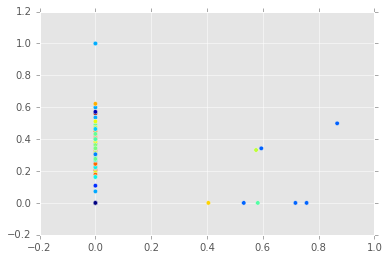

0.0897995116494
0.694221694603


In [14]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet

print(X.shape)
Z = linkage(X,'ward')
Zcos = linkage(X,metric='cosine',method='complete')
labels = fcluster(Zcos, .1, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float)) 
plt.show()

c, coph_dists = cophenet(Z,pdist(X))
print(c)
c, coph_dists = cophenet(Zcos,pdist(X))
print(c) 

The Cophenetic Correlation Coefficient compares (correlates) the actual pairwise distances of all our samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances. We will go with the cos distance, since that is more standard for text, and also closer to one. However, as this number shows, there's a significant account of variation left unaccounted for.

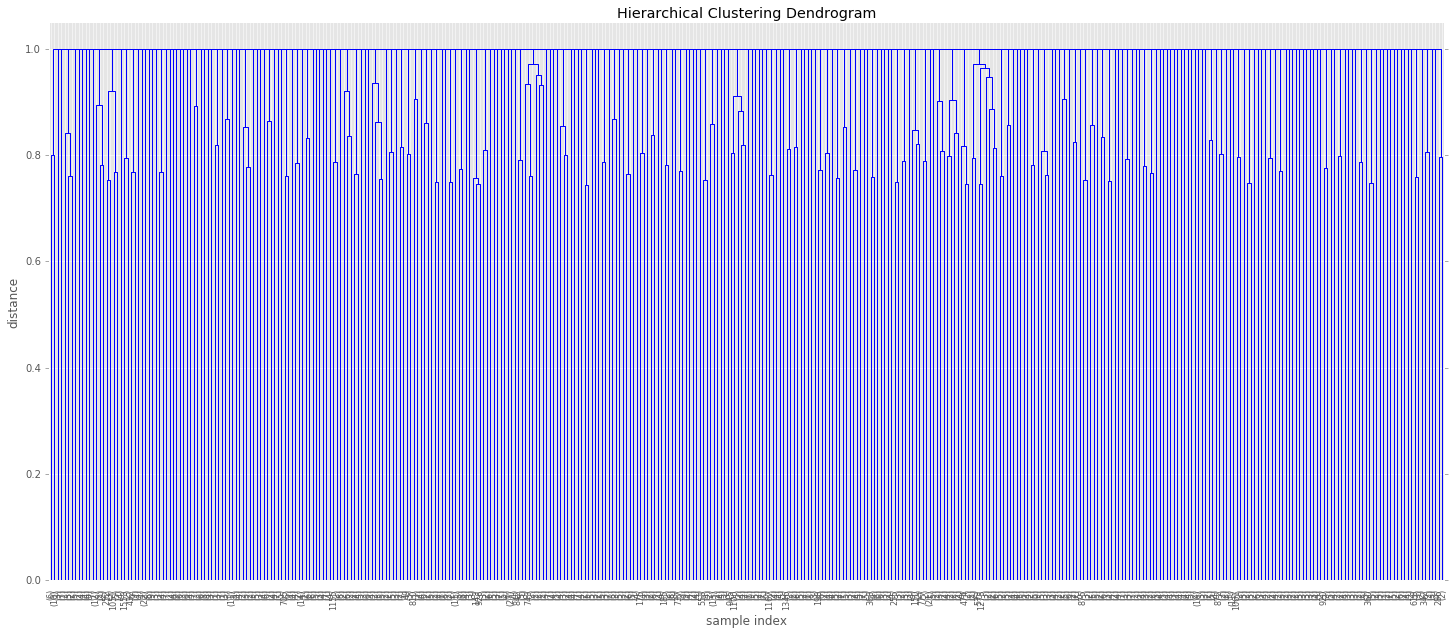

In [28]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Zcos,
    truncate_mode = 'lastp',
    p=400,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Takeaway: There are too many clusters, and no principled way to decrease that number. Perhaps if we include other data?